In [51]:
# Importing the libraries
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from skimage import io, transform


# Setting some hyperparameters
batchSize = 64 # We set the size of the batch.
imageSize = 64 # We set the size of the generated images (64x64).

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Training Data

Training data contained in data folder.<br>
Scraped images from a google search to replicate football celebrations.<br>
Used the following search terms. <br>

'goal celebration'<br>
'goal scorer celebrate'<br>
'sports celebration'<br>

Really good tutorial on datasets for images in pytorch. <br>
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html <br>

# Data Exploration

In [52]:
def show_image(image):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

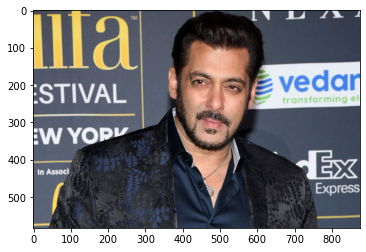

In [53]:
# Lets have a look at one of the images
plt.figure()
show_image(io.imread(os.path.join('data/', 'salman.jpg')))
plt.show()

In [54]:
# List all the file names of the training data in question
file_list = os.listdir('data/')

# Custom Datasets

In [55]:
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
goal_dataset = datasets.ImageFolder(os.path.join('./'),
                                           transform=data_transform)
dataloader = torch.utils.data.DataLoader(goal_dataset,
                                             batch_size=64, shuffle=True,
                                             num_workers=2)

In [56]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [57]:
# Defining the generator

class G(nn.Module): # We introduce a class to define the generator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the generator.
        super(G, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False), # We start with an inversed convolution.
            nn.BatchNorm2d(512), # We normalize all the features along the dimension of the batch.
            nn.ReLU(True), # We apply a ReLU rectification to break the linearity.
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(128), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(64), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.Tanh() # We apply a Tanh rectification to break the linearity and stay between -1 and +1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output containing the generated images.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the generator defined by self.main.
        return output # We return the output containing the generated images.


In [58]:
# Creating the generator
netG = G() # We create the generator object.
netG.apply(weights_init) # We initialize all the weights of its neural network.

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [59]:
# Defining the discriminator

class D(nn.Module): # We introduce a class to define the discriminator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the discriminator.
        super(D, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.Conv2d(3, 64, 4, 2, 1, bias = False), # We start with a convolution.
            nn.LeakyReLU(0.2, inplace = True), # We apply a LeakyReLU.
            nn.Conv2d(64, 128, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(128), # We normalize all the features along the dimension of the batch.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(256, 512, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(512), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), # We add another convolution.
            nn.Sigmoid() # We apply a Sigmoid rectification to break the linearity and stay between 0 and 1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output which will be a value between 0 and 1.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the discriminator defined by self.main.
        return output.view(-1) # We return the output which will be a value between 0 and 1.


In [60]:
# Creating the discriminator
netD = D() # We create the discriminator object.
netD.apply(weights_init) # We initialize all the weights of its neural network.


D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [61]:
# Training the DCGANs

criterion = nn.BCELoss() # We create a criterion object that will measure the error between the prediction and the target.
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the discriminator.
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the generator.


In [ ]:
for epoch in range(25): # We iterate over ... epochs.

    for i, data in enumerate(dataloader, 0): # We iterate over the images of the dataset.
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        netD.zero_grad() # We initialize to 0 the gradients of the discriminator with respect to the weights.
        # Training the discriminator with a real image of the dataset
        real, _ = data # We get a real image of the dataset which will be used to train the discriminator.
        input = Variable(real) # We wrap it in a variable.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(input) # We forward propagate this real image into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_real = criterion(output, target) # We compute the loss between the predictions (output) and the target (equal to 1).
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)) # We make a random input vector (noise) of the generator.
        fake = netG(noise) # We forward propagate this random input vector into the neural network of the generator to get some fake generated images.
        target = Variable(torch.zeros(input.size()[0])) # We get the target.
        output = netD(fake.detach()) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_fake = criterion(output, target) # We compute the loss between the prediction (output) and the target (equal to 0).

         # Backpropagating the total error
        errD = errD_real + errD_fake # We compute the total error of the discriminator.
        errD.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the discriminator.
        optimizerD.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the discriminator.

        
        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad() # We initialize to 0 the gradients of the generator with respect to the weights.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(fake) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errG = criterion(output, target) # We compute the loss between the prediction (output between 0 and 1) and the target (equal to 1).
        errG.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the generator.
        optimizerG.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the generator.
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.data.item(), errG.data.item())) # We print les losses of the discriminator (Loss_D) and the generator (Loss_G).
        if i % 500 == 0: # Every 100 steps:
            vutils.save_image(real, '%s/real_celebrations.png' % "./results", normalize = True) # We save the real images of the minibatch.
            fake = netG(noise) # We get our fake generated images.
            vutils.save_image(fake.data, '%s/fake_celebrate%03d.png' % ("./results", epoch), normalize = True) # We also save the fake generated images of the minibatch.


[0/25][0/113] Loss_D: 1.3990 Loss_G: 6.5341
[0/25][1/113] Loss_D: 0.8911 Loss_G: 5.6415
[0/25][2/113] Loss_D: 0.7886 Loss_G: 5.9656
[0/25][3/113] Loss_D: 0.8447 Loss_G: 6.3997
[0/25][4/113] Loss_D: 0.7966 Loss_G: 6.9570
[0/25][5/113] Loss_D: 0.9330 Loss_G: 6.6266
[0/25][6/113] Loss_D: 1.0691 Loss_G: 8.5606
[0/25][7/113] Loss_D: 0.5380 Loss_G: 6.9377
[0/25][8/113] Loss_D: 0.8551 Loss_G: 8.4251
[0/25][9/113] Loss_D: 0.4540 Loss_G: 9.0009
[0/25][10/113] Loss_D: 0.6046 Loss_G: 9.4359
[0/25][11/113] Loss_D: 0.7622 Loss_G: 10.3213
[0/25][12/113] Loss_D: 0.5125 Loss_G: 8.6478
[0/25][13/113] Loss_D: 0.6298 Loss_G: 11.9861
[0/25][14/113] Loss_D: 0.4003 Loss_G: 8.8880
[0/25][15/113] Loss_D: 0.8633 Loss_G: 14.4588
[0/25][16/113] Loss_D: 0.5243 Loss_G: 11.4999
[0/25][17/113] Loss_D: 0.3162 Loss_G: 8.7388
[0/25][18/113] Loss_D: 1.2508 Loss_G: 17.4664
[0/25][19/113] Loss_D: 0.2610 Loss_G: 16.5014
[0/25][20/113] Loss_D: 0.2026 Loss_G: 8.9958
[0/25][21/113] Loss_D: 2.5615 Loss_G: 18.4614
[0/25][22/113

[1/25][68/113] Loss_D: 0.8684 Loss_G: 4.7477
[1/25][69/113] Loss_D: 0.5218 Loss_G: 3.7213
[1/25][70/113] Loss_D: 0.2158 Loss_G: 3.6693
[1/25][71/113] Loss_D: 0.3836 Loss_G: 4.4648
[1/25][72/113] Loss_D: 0.2284 Loss_G: 3.9493
[1/25][73/113] Loss_D: 0.2853 Loss_G: 3.3817
[1/25][74/113] Loss_D: 0.3263 Loss_G: 3.6157
[1/25][75/113] Loss_D: 0.3659 Loss_G: 5.0264
[1/25][76/113] Loss_D: 0.7251 Loss_G: 1.4011
[1/25][77/113] Loss_D: 1.7476 Loss_G: 8.1890
[1/25][78/113] Loss_D: 2.9207 Loss_G: 4.6331
[1/25][79/113] Loss_D: 0.7106 Loss_G: 1.2282
[1/25][80/113] Loss_D: 1.0064 Loss_G: 4.9762
[1/25][81/113] Loss_D: 0.4709 Loss_G: 4.7223
[1/25][82/113] Loss_D: 0.2189 Loss_G: 3.5036
[1/25][83/113] Loss_D: 0.2668 Loss_G: 3.5938
[1/25][84/113] Loss_D: 0.2787 Loss_G: 3.6308
[1/25][85/113] Loss_D: 0.2915 Loss_G: 3.5702
[1/25][86/113] Loss_D: 0.2360 Loss_G: 4.0224
[1/25][87/113] Loss_D: 0.2228 Loss_G: 3.8639
[1/25][88/113] Loss_D: 0.3009 Loss_G: 3.6203
[1/25][89/113] Loss_D: 0.3751 Loss_G: 2.9908
[1/25][90/

[3/25][24/113] Loss_D: 0.3679 Loss_G: 4.3854
[3/25][25/113] Loss_D: 0.2953 Loss_G: 3.8129
[3/25][26/113] Loss_D: 0.4375 Loss_G: 5.7699
[3/25][27/113] Loss_D: 0.5335 Loss_G: 2.0451
[3/25][28/113] Loss_D: 0.6986 Loss_G: 6.4790
[3/25][29/113] Loss_D: 0.5460 Loss_G: 4.3715
[3/25][30/113] Loss_D: 0.2469 Loss_G: 2.9802
[3/25][31/113] Loss_D: 0.4705 Loss_G: 5.7664
[3/25][32/113] Loss_D: 0.3647 Loss_G: 4.5938
[3/25][33/113] Loss_D: 0.3291 Loss_G: 2.8631
[3/25][34/113] Loss_D: 0.6830 Loss_G: 4.5793
[3/25][35/113] Loss_D: 0.5176 Loss_G: 2.7416
[3/25][36/113] Loss_D: 0.5272 Loss_G: 4.1682
[3/25][37/113] Loss_D: 0.3095 Loss_G: 3.4536
[3/25][38/113] Loss_D: 0.3411 Loss_G: 3.8836
[3/25][39/113] Loss_D: 0.4978 Loss_G: 3.6532
[3/25][40/113] Loss_D: 0.5420 Loss_G: 2.4459
[3/25][41/113] Loss_D: 0.9986 Loss_G: 6.3036
[3/25][42/113] Loss_D: 1.9159 Loss_G: 0.5488
[3/25][43/113] Loss_D: 2.6267 Loss_G: 8.2823
[3/25][44/113] Loss_D: 2.8081 Loss_G: 3.5345
[3/25][45/113] Loss_D: 0.8934 Loss_G: 3.0065
[3/25][46/

[4/25][93/113] Loss_D: 0.2564 Loss_G: 3.7387
[4/25][94/113] Loss_D: 0.3577 Loss_G: 3.4136
[4/25][95/113] Loss_D: 0.5704 Loss_G: 4.4224
[4/25][96/113] Loss_D: 0.2710 Loss_G: 3.6622
[4/25][97/113] Loss_D: 0.4065 Loss_G: 3.5824
[4/25][98/113] Loss_D: 0.2786 Loss_G: 4.1732
[4/25][99/113] Loss_D: 0.2198 Loss_G: 4.1640
[4/25][100/113] Loss_D: 0.4048 Loss_G: 3.6282
[4/25][101/113] Loss_D: 0.4748 Loss_G: 3.0659
[4/25][102/113] Loss_D: 0.5923 Loss_G: 5.9561
[4/25][103/113] Loss_D: 0.9442 Loss_G: 0.4025
[4/25][104/113] Loss_D: 2.4638 Loss_G: 9.5949
[4/25][105/113] Loss_D: 1.9081 Loss_G: 0.3156
[4/25][106/113] Loss_D: 3.3606 Loss_G: 7.9060
[4/25][107/113] Loss_D: 1.8027 Loss_G: 5.1574
[4/25][108/113] Loss_D: 0.5147 Loss_G: 2.8802
[4/25][109/113] Loss_D: 1.2103 Loss_G: 4.9504
[4/25][110/113] Loss_D: 0.9901 Loss_G: 2.9290
[4/25][111/113] Loss_D: 1.8231 Loss_G: 3.2557
[4/25][112/113] Loss_D: 2.0777 Loss_G: 3.3506
[5/25][0/113] Loss_D: 2.0679 Loss_G: 2.8263
[5/25][1/113] Loss_D: 1.4337 Loss_G: 3.1401

[6/25][49/113] Loss_D: 0.2767 Loss_G: 4.1461
[6/25][50/113] Loss_D: 0.3409 Loss_G: 4.8845
[6/25][51/113] Loss_D: 0.4055 Loss_G: 4.3799
[6/25][52/113] Loss_D: 0.2222 Loss_G: 5.7575
[6/25][53/113] Loss_D: 0.4837 Loss_G: 3.0668
[6/25][54/113] Loss_D: 0.6986 Loss_G: 9.2955
[6/25][55/113] Loss_D: 0.8784 Loss_G: 6.7727
[6/25][56/113] Loss_D: 0.1162 Loss_G: 3.9986
[6/25][57/113] Loss_D: 0.5527 Loss_G: 6.9315
[6/25][58/113] Loss_D: 0.4068 Loss_G: 5.2415
[6/25][59/113] Loss_D: 0.1930 Loss_G: 3.4604
[6/25][60/113] Loss_D: 0.6270 Loss_G: 6.9417
[6/25][61/113] Loss_D: 0.6098 Loss_G: 4.6392
[6/25][62/113] Loss_D: 0.2458 Loss_G: 3.5539
[6/25][63/113] Loss_D: 0.2544 Loss_G: 5.3511
[6/25][64/113] Loss_D: 0.2156 Loss_G: 4.9231
[6/25][65/113] Loss_D: 0.2509 Loss_G: 4.3934
[6/25][66/113] Loss_D: 0.3650 Loss_G: 6.3490
[6/25][67/113] Loss_D: 0.6364 Loss_G: 1.9691
[6/25][68/113] Loss_D: 0.7440 Loss_G: 9.4935
[6/25][69/113] Loss_D: 0.4490 Loss_G: 8.5270
[6/25][70/113] Loss_D: 0.3483 Loss_G: 4.3061
[6/25][71/

[8/25][5/113] Loss_D: 1.0046 Loss_G: 0.7004
[8/25][6/113] Loss_D: 2.0301 Loss_G: 7.1666
[8/25][7/113] Loss_D: 1.0700 Loss_G: 2.1464
[8/25][8/113] Loss_D: 1.0584 Loss_G: 6.7376
[8/25][9/113] Loss_D: 0.6282 Loss_G: 4.4612
[8/25][10/113] Loss_D: 0.3369 Loss_G: 3.2083
[8/25][11/113] Loss_D: 0.3865 Loss_G: 4.7540
[8/25][12/113] Loss_D: 0.4573 Loss_G: 3.4674
[8/25][13/113] Loss_D: 0.3182 Loss_G: 3.6778
[8/25][14/113] Loss_D: 0.2187 Loss_G: 3.9528
[8/25][15/113] Loss_D: 0.4135 Loss_G: 5.4818
[8/25][16/113] Loss_D: 0.1915 Loss_G: 5.0266
[8/25][17/113] Loss_D: 0.2460 Loss_G: 3.5354
[8/25][18/113] Loss_D: 0.5694 Loss_G: 4.7169
[8/25][19/113] Loss_D: 0.6726 Loss_G: 3.4549
[8/25][20/113] Loss_D: 0.4927 Loss_G: 3.3655
[8/25][21/113] Loss_D: 0.5383 Loss_G: 5.6834
[8/25][22/113] Loss_D: 0.5608 Loss_G: 3.3642
[8/25][23/113] Loss_D: 0.6248 Loss_G: 4.8788
[8/25][24/113] Loss_D: 0.5048 Loss_G: 3.0273
[8/25][25/113] Loss_D: 0.4493 Loss_G: 5.1451
[8/25][26/113] Loss_D: 0.2220 Loss_G: 4.8104
[8/25][27/113] 

[9/25][75/113] Loss_D: 0.4142 Loss_G: 3.9441
[9/25][76/113] Loss_D: 0.3292 Loss_G: 3.4438
[9/25][77/113] Loss_D: 0.2040 Loss_G: 3.6149
[9/25][78/113] Loss_D: 0.3885 Loss_G: 2.5500
[9/25][79/113] Loss_D: 0.3469 Loss_G: 3.8995
[9/25][80/113] Loss_D: 0.2979 Loss_G: 4.2211
[9/25][81/113] Loss_D: 0.1933 Loss_G: 3.8886
[9/25][82/113] Loss_D: 0.2091 Loss_G: 3.4712
[9/25][83/113] Loss_D: 0.2911 Loss_G: 5.1046
[9/25][84/113] Loss_D: 0.3430 Loss_G: 3.3147
[9/25][85/113] Loss_D: 0.2079 Loss_G: 3.6333
[9/25][86/113] Loss_D: 0.2793 Loss_G: 4.7199
[9/25][87/113] Loss_D: 0.3007 Loss_G: 3.8339
[9/25][88/113] Loss_D: 0.3851 Loss_G: 4.9253
[9/25][89/113] Loss_D: 0.2415 Loss_G: 3.8971
[9/25][90/113] Loss_D: 0.4930 Loss_G: 3.1547
[9/25][91/113] Loss_D: 0.2961 Loss_G: 5.1356
[9/25][92/113] Loss_D: 0.2568 Loss_G: 4.2429
[9/25][93/113] Loss_D: 0.2491 Loss_G: 4.3474
[9/25][94/113] Loss_D: 0.2515 Loss_G: 4.2763
[9/25][95/113] Loss_D: 0.3341 Loss_G: 3.8524
[9/25][96/113] Loss_D: 0.4173 Loss_G: 5.9387
[9/25][97/

[11/25][28/113] Loss_D: 0.2118 Loss_G: 5.2791
[11/25][29/113] Loss_D: 0.1549 Loss_G: 4.3709
[11/25][30/113] Loss_D: 0.1858 Loss_G: 4.4225
[11/25][31/113] Loss_D: 0.3533 Loss_G: 3.7930
[11/25][32/113] Loss_D: 0.5276 Loss_G: 6.3562
[11/25][33/113] Loss_D: 0.5503 Loss_G: 3.6956
[11/25][34/113] Loss_D: 0.5311 Loss_G: 5.4559
[11/25][35/113] Loss_D: 0.4025 Loss_G: 4.8698
[11/25][36/113] Loss_D: 0.4722 Loss_G: 2.5436
[11/25][37/113] Loss_D: 0.6346 Loss_G: 7.9644
[11/25][38/113] Loss_D: 0.6135 Loss_G: 4.2424
[11/25][39/113] Loss_D: 0.2518 Loss_G: 4.1168
[11/25][40/113] Loss_D: 0.3697 Loss_G: 6.0712
[11/25][41/113] Loss_D: 0.2226 Loss_G: 4.8865
[11/25][42/113] Loss_D: 0.3526 Loss_G: 4.4304
[11/25][43/113] Loss_D: 0.6446 Loss_G: 1.9642
[11/25][44/113] Loss_D: 1.0179 Loss_G: 7.9290
[11/25][45/113] Loss_D: 1.3258 Loss_G: 2.0211
[11/25][46/113] Loss_D: 0.7505 Loss_G: 5.7908
[11/25][47/113] Loss_D: 0.7057 Loss_G: 1.5153
[11/25][48/113] Loss_D: 1.1118 Loss_G: 6.6759
[11/25][49/113] Loss_D: 1.0326 Los

[12/25][93/113] Loss_D: 0.4743 Loss_G: 3.4138
[12/25][94/113] Loss_D: 0.5688 Loss_G: 2.7957
[12/25][95/113] Loss_D: 0.3209 Loss_G: 4.3878
[12/25][96/113] Loss_D: 0.4558 Loss_G: 3.3169
[12/25][97/113] Loss_D: 0.2509 Loss_G: 3.8977
[12/25][98/113] Loss_D: 0.1590 Loss_G: 4.3084
[12/25][99/113] Loss_D: 0.1989 Loss_G: 3.6101
[12/25][100/113] Loss_D: 0.2695 Loss_G: 4.0297
[12/25][101/113] Loss_D: 0.2439 Loss_G: 4.1597
[12/25][102/113] Loss_D: 0.3698 Loss_G: 2.8824
[12/25][103/113] Loss_D: 0.5493 Loss_G: 4.6610
[12/25][104/113] Loss_D: 0.2713 Loss_G: 4.6137
[12/25][105/113] Loss_D: 0.4667 Loss_G: 2.6504
[12/25][106/113] Loss_D: 0.7252 Loss_G: 6.8717
[12/25][107/113] Loss_D: 1.3414 Loss_G: 2.7202
[12/25][108/113] Loss_D: 0.6458 Loss_G: 5.5036
[12/25][109/113] Loss_D: 0.2745 Loss_G: 5.7903
[12/25][110/113] Loss_D: 0.2132 Loss_G: 4.1154
[12/25][111/113] Loss_D: 0.4546 Loss_G: 4.4965
[12/25][112/113] Loss_D: 0.2651 Loss_G: 4.7622
[13/25][0/113] Loss_D: 0.7480 Loss_G: 4.5655
[13/25][1/113] Loss_D:

[14/25][45/113] Loss_D: 0.4864 Loss_G: 3.3575
[14/25][46/113] Loss_D: 0.3223 Loss_G: 2.9416
[14/25][47/113] Loss_D: 0.2222 Loss_G: 3.6497
[14/25][48/113] Loss_D: 0.2172 Loss_G: 4.0162
[14/25][49/113] Loss_D: 0.1520 Loss_G: 4.1772
[14/25][50/113] Loss_D: 0.3168 Loss_G: 2.9864
[14/25][51/113] Loss_D: 0.6621 Loss_G: 5.5702
[14/25][52/113] Loss_D: 0.4662 Loss_G: 3.0119
[14/25][53/113] Loss_D: 0.6372 Loss_G: 4.9777
[14/25][54/113] Loss_D: 0.5275 Loss_G: 3.9413
[14/25][55/113] Loss_D: 0.3312 Loss_G: 4.0643
[14/25][56/113] Loss_D: 0.3353 Loss_G: 4.3206
[14/25][57/113] Loss_D: 0.4294 Loss_G: 2.7467
[14/25][58/113] Loss_D: 0.4780 Loss_G: 5.5732
[14/25][59/113] Loss_D: 0.3564 Loss_G: 4.2142
[14/25][60/113] Loss_D: 0.3714 Loss_G: 3.1404
[14/25][61/113] Loss_D: 0.2970 Loss_G: 5.1177
[14/25][62/113] Loss_D: 0.4923 Loss_G: 2.7754
[14/25][63/113] Loss_D: 0.7459 Loss_G: 5.6194
[14/25][64/113] Loss_D: 0.3879 Loss_G: 4.9964
[14/25][65/113] Loss_D: 0.3044 Loss_G: 2.7205
[14/25][66/113] Loss_D: 0.5593 Los

[15/25][110/113] Loss_D: 0.2563 Loss_G: 3.1712
[15/25][111/113] Loss_D: 0.4287 Loss_G: 4.8271
[15/25][112/113] Loss_D: 0.3093 Loss_G: 3.6899
[16/25][0/113] Loss_D: 0.2500 Loss_G: 4.2049
[16/25][1/113] Loss_D: 0.4280 Loss_G: 3.9328
[16/25][2/113] Loss_D: 0.3003 Loss_G: 3.4259
[16/25][3/113] Loss_D: 0.4480 Loss_G: 4.1353
[16/25][4/113] Loss_D: 0.2875 Loss_G: 4.1033
[16/25][5/113] Loss_D: 0.3029 Loss_G: 4.1237
[16/25][6/113] Loss_D: 0.4699 Loss_G: 3.8115
[16/25][7/113] Loss_D: 0.3563 Loss_G: 4.0572
[16/25][8/113] Loss_D: 0.3958 Loss_G: 4.0596
[16/25][9/113] Loss_D: 0.2550 Loss_G: 4.6831
[16/25][10/113] Loss_D: 0.5676 Loss_G: 2.6988
[16/25][11/113] Loss_D: 0.3663 Loss_G: 5.2121
[16/25][12/113] Loss_D: 0.2326 Loss_G: 4.7296
[16/25][13/113] Loss_D: 0.2506 Loss_G: 3.5960
[16/25][14/113] Loss_D: 0.3459 Loss_G: 4.9765
[16/25][15/113] Loss_D: 0.4708 Loss_G: 3.5112
[16/25][16/113] Loss_D: 0.5013 Loss_G: 4.3829
[16/25][17/113] Loss_D: 0.1357 Loss_G: 4.8048
[16/25][18/113] Loss_D: 0.2697 Loss_G: 3.

[17/25][63/113] Loss_D: 0.3706 Loss_G: 3.9250
[17/25][64/113] Loss_D: 0.3904 Loss_G: 3.3581
[17/25][65/113] Loss_D: 0.4315 Loss_G: 4.2624
[17/25][66/113] Loss_D: 0.3453 Loss_G: 3.6950
[17/25][67/113] Loss_D: 0.2772 Loss_G: 3.9169
[17/25][68/113] Loss_D: 0.2872 Loss_G: 4.0519
[17/25][69/113] Loss_D: 0.2992 Loss_G: 3.5949
[17/25][70/113] Loss_D: 0.3661 Loss_G: 3.7131
[17/25][71/113] Loss_D: 0.3345 Loss_G: 3.3990
[17/25][72/113] Loss_D: 0.2779 Loss_G: 4.3252
[17/25][73/113] Loss_D: 0.3459 Loss_G: 3.4779
[17/25][74/113] Loss_D: 0.4078 Loss_G: 4.8478
[17/25][75/113] Loss_D: 0.5744 Loss_G: 1.9960
[17/25][76/113] Loss_D: 0.7052 Loss_G: 6.4778
[17/25][77/113] Loss_D: 0.6020 Loss_G: 3.8775
[17/25][78/113] Loss_D: 0.1948 Loss_G: 2.8833
[17/25][79/113] Loss_D: 0.5942 Loss_G: 5.6512
[17/25][80/113] Loss_D: 0.4091 Loss_G: 5.4283
[17/25][81/113] Loss_D: 0.1528 Loss_G: 3.2186
[17/25][82/113] Loss_D: 0.1799 Loss_G: 3.4954
[17/25][83/113] Loss_D: 0.3028 Loss_G: 5.3614
[17/25][84/113] Loss_D: 0.3044 Los

[19/25][15/113] Loss_D: 0.5269 Loss_G: 3.3672
[19/25][16/113] Loss_D: 0.4587 Loss_G: 4.1001
[19/25][17/113] Loss_D: 0.3056 Loss_G: 4.4943
[19/25][18/113] Loss_D: 0.4774 Loss_G: 2.1000
[19/25][19/113] Loss_D: 0.6294 Loss_G: 6.6413
[19/25][20/113] Loss_D: 0.5498 Loss_G: 3.4229
[19/25][21/113] Loss_D: 0.3124 Loss_G: 4.1008
[19/25][22/113] Loss_D: 0.3250 Loss_G: 3.9695
[19/25][23/113] Loss_D: 0.3796 Loss_G: 3.0415
[19/25][24/113] Loss_D: 0.2167 Loss_G: 4.3297
[19/25][25/113] Loss_D: 0.2798 Loss_G: 3.4078
[19/25][26/113] Loss_D: 0.2572 Loss_G: 4.6927
[19/25][27/113] Loss_D: 0.3507 Loss_G: 2.4801
[19/25][28/113] Loss_D: 0.3087 Loss_G: 4.0817
[19/25][29/113] Loss_D: 0.3078 Loss_G: 3.3024
[19/25][30/113] Loss_D: 0.3076 Loss_G: 3.2087
[19/25][31/113] Loss_D: 0.4249 Loss_G: 4.6987
[19/25][32/113] Loss_D: 0.2993 Loss_G: 3.3193
[19/25][33/113] Loss_D: 0.3642 Loss_G: 2.5211
[19/25][34/113] Loss_D: 0.4281 Loss_G: 5.3136
[19/25][35/113] Loss_D: 0.6794 Loss_G: 1.6987
[19/25][36/113] Loss_D: 0.6229 Los